## Домашнее задание 4
* Сравнить LSTM, RNN и GRU на задаче предсказания части речи (качество предсказания, скорость обучения, время инференса модели)
* *к первой задаче добавить bidirectional

In [39]:
import time
import warnings
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from os.path import exists
warnings.filterwarnings('ignore')

In [40]:
class DatasetSeq(Dataset):
    def __init__(self, data_dir, train_lang='en'):
	#open file
        with open(data_dir + train_lang + '.train', 'r') as f:
            train = f.read().split('\n\n')

        # delete extra tag markup
        train = [x for x in train if not '_ ' in x]
	    #init vocabs of tokens for encoding { token:  id}
        self.target_vocab = {} # {p: 1, a: 2, r: 3, pu: 4}
        self.word_vocab = {} # {cat: 1, sat: 2, on: 3, mat: 4, '.': 5}
        self.char_vocab = {} # {c: 1, a: 2, t: 3, ' ': 4, s: 5}
	    
        # Cat sat on mat. -> [1, 2, 3, 4, 5]
        # p    a  r  p pu -> [1, 2, 3, 1, 4]
        # chars  -> [1, 2, 3, 4, 5, 2, 3, 4]

	    #init encoded sequences lists (processed data)
        self.encoded_sequences = []
        self.encoded_targets = []
        self.encoded_char_sequences = []
        # n=1 because first value is padding
        n_word = 1
        n_target = 1
        n_char = 1
        for line in train:
            sequence = []
            target = []
            chars = []
            for item in line.split('\n'):
                if item != '':
                    word, label = item.split(' ')

                    if self.word_vocab.get(word) is None:
                        self.word_vocab[word] = n_word
                        n_word += 1
                    if self.target_vocab.get(label) is None:
                        self.target_vocab[label] = n_target
                        n_target += 1
                    for char in word:
                        if self.char_vocab.get(char) is None:
                            self.char_vocab[char] = n_char
                            n_char += 1
                    sequence.append(self.word_vocab[word])
                    target.append(self.target_vocab[label])
                    chars.append([self.char_vocab[char] for char in word])
            self.encoded_sequences.append(sequence)
            self.encoded_targets.append(target)
            self.encoded_char_sequences.append(chars)

    def __len__(self):
        return len(self.encoded_sequences)

    def __getitem__(self, index):
        return {
            'data': self.encoded_sequences[index], # [1, 2, 3, 4, 6] len=5
            'char': self.encoded_char_sequences[index],# [[1,2,3], [4,5], [1,2], [2,6,5,4], []] len=5
            'target': self.encoded_targets[index], #  (1)
        }

dataset = DatasetSeq('')        

In [41]:
def collate_fn(batch):
    data = []
    target = []
    for item in batch:
        data.append(torch.as_tensor(item['data']))
        target.append(torch.as_tensor(item['target']))
    data = pad_sequence(data, batch_first=True, padding_value=0)
    target = pad_sequence(target, batch_first=True, padding_value=0)

    return {'data': data, 'target': target}
     

In [42]:

class RNNPredictorV2(nn.Module):
    # ну я тут добавил параметр, которым будет задаваться класс, модель с которым нам нужно создать
    def __init__(self, vocab_size, emb_dim, hidden_dim, n_classes, cl):
        super().__init__()
        self.word_emb = nn.Embedding(vocab_size, emb_dim)
        #TODO try to use other RNN archicetures, f.e. RNN and LSTM
        self.word_emb = nn.Embedding(vocab_size, emb_dim)
        # соответственно здесь - инициируется как раз объект этого класса, то есть модель в каждом случае  будет разная
        self.rnn = cl(emb_dim, hidden_dim, batch_first=True)
        self.clf = nn.Linear(hidden_dim, n_classes)
        self.do = nn.Dropout(0.1)
    
    def forward(self, x):
        emb = self.word_emb(x) # B x T x Emb_dim
        hidden, _ = self.rnn(emb) # B x T x Hid, B x 1 x Hid
        pred = self.clf(self.do(hidden)) # B x T x N_classes

        return pred

In [43]:
#hyper params
vocab_size = len(dataset.word_vocab) + 1
n_classes = len(dataset.target_vocab) + 1
n_chars = len(dataset.char_vocab) + 1
#TODO try to use other model parameters
emb_dim = 128
hidden = 128
n_epochs = 10
batch_size = 100
device = 'cpu'

In [44]:
# здесь я формирую три объекта модели и соответсвующего оптимизатора
model_rnn = RNNPredictorV2(vocab_size, emb_dim, hidden, n_classes, nn.RNN).to(device)
model_rnn.train()
optim_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

model_lstm = RNNPredictorV2(vocab_size, emb_dim, hidden, n_classes, nn.LSTM).to(device)
model_lstm.train()
optim_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

model_gru = RNNPredictorV2(vocab_size, emb_dim, hidden, n_classes, nn.GRU).to(device)
model_gru.train()
optim_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [45]:
epoch_stats_df = pd.DataFrame(columns=['Epoch','RNN', 'LSTM', 'GRU'])

In [46]:
# служебный класс для прогона "эпохи"
def process_epoch(model: nn.Module, optimizer: torch.optim.Optimizer):
    time_before = time.time()
    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()
        predict = model(batch['data'].to(device))
        loss = loss_func(predict.view(-1, n_classes),
                         batch['target'].to(device).view(-1),
                         )
        loss.backward()
        optimizer.step()
    time_after = time.time()
    return time_after-time_before

if not exists('learning_stats.pickle'):
# обучающий цикл. он будет один, за одну эпоху обучаем все три модели. продолжительность эпохи длякаджой модели записываем в датафрейм
    for epoch in range(n_epochs):
        dataloader = DataLoader(dataset, 
                                batch_size, 
                                shuffle=True, 
                                collate_fn=collate_fn,
                                drop_last = True,
                                )
        ### rnn
        rnn_epoch_duration = process_epoch(model_rnn, optim_rnn)
        lstm_epoch_duration = process_epoch(model_lstm, optim_lstm)
        gru_epoch_duration = process_epoch(model_gru, optim_gru)
        print(f'rnn epoch:{epoch}| rnn: {rnn_epoch_duration}, lstm epoch: {lstm_epoch_duration}, gru: {gru_epoch_duration}')
        epoch_stats_df = epoch_stats_df.append({'Epoch': epoch, 'RNN':rnn_epoch_duration, 'LSTM':lstm_epoch_duration, 'GRU':gru_epoch_duration},ignore_index=True)
        torch.save(model_rnn, 'my_rnn_model.pickle')
        torch.save(model_lstm, 'my_lstm_model.pickle')
        torch.save(model_gru, 'my_gru_model.pickle')

        epoch_stats_df.to_pickle('learning_stats.pickle')
else:
    epoch_stats_df = pd.read_pickle('learning_stats.pickle')
    model_rnn = torch.load('my_rnn_model.pickle')
    model_lstm = torch.load('my_lstm_model.pickle')
    model_gru = torch.load('my_gru_model.pickle')
    
print('here is dataframe with epoch epochs statistics')



rnn epoch:0| rnn: 6.24646520614624, lstm epoch: 13.578176975250244, gru: 11.948695182800293
rnn epoch:1| rnn: 6.3876729011535645, lstm epoch: 13.677088975906372, gru: 11.525660753250122
rnn epoch:2| rnn: 6.40909481048584, lstm epoch: 13.22965407371521, gru: 11.384986162185669
rnn epoch:3| rnn: 6.224084138870239, lstm epoch: 13.220654010772705, gru: 11.276286125183105
rnn epoch:4| rnn: 6.17740797996521, lstm epoch: 13.328155040740967, gru: 11.572083950042725
rnn epoch:5| rnn: 6.322181224822998, lstm epoch: 13.322430849075317, gru: 12.128712892532349
rnn epoch:6| rnn: 6.2940521240234375, lstm epoch: 13.571205854415894, gru: 11.397433996200562
rnn epoch:7| rnn: 6.2475950717926025, lstm epoch: 13.449328899383545, gru: 11.632580280303955
rnn epoch:8| rnn: 6.498455047607422, lstm epoch: 13.316591024398804, gru: 11.571944236755371
rnn epoch:9| rnn: 6.31983494758606, lstm epoch: 13.560894966125488, gru: 11.778913021087646
here is dataframe with epoch epochs statistics


In [47]:
epoch_stats_df

,Epoch,RNN,LSTM,GRU
0,0.0,6.246465,13.578177,11.948695
1,1.0,6.387673,13.677089,11.525661
2,2.0,6.409095,13.229654,11.384986
3,3.0,6.224084,13.220654,11.276286
4,4.0,6.177408,13.328155,11.572084
5,5.0,6.322181,13.322431,12.128713
6,6.0,6.294052,13.571206,11.397434
7,7.0,6.247595,13.449329,11.632580
8,8.0,6.498455,13.316591,11.571944
9,9.0,6.319835,13.560895,11.778913


<AxesSubplot:title={'center':'Статистика времени обучения'}, xlabel='Epoch'>

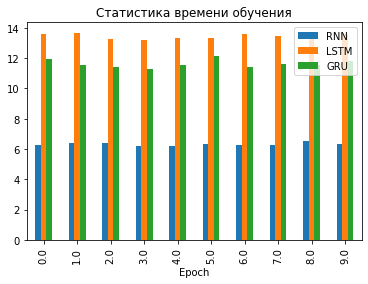

In [48]:
epoch_stats_df_with_index = epoch_stats_df.set_index('Epoch')
epoch_stats_df_with_index.plot(title = 'Статистика времени обучения', kind='bar' )
